In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/CS 495 DataScience Capstone Project/

Mounted at /content/drive
/content/drive/My Drive/CS 495 DataScience Capstone Project


# Anime Synopsis Generator - LSTM Inference & Evaluation

This Notebook evaluates a trained LSTM model by generating synopses from test prompts and comparing them to ground truth synopses using embeddings and perplexity.

**Key Features:**

- Prompt-to-synopsis generation using temperature sampling
- Evaluation with cosine similarity (Sentence-BERT)
- Language modeling perplexity calculation
- UMAP projection of prompt/output embeddings


**Input:** 'prompt_synopsis_train.csv'

**Model:** 'lstm_model_keras' + 'lstm_tokenizer.pkl'

**Metrics:** Cosine Similarity, Perplexity

**Output:** 'lstm_results.csv' and UMAP plot

# I. Load Model and Tokenizer

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import umap
import pickle
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

# II. Load Model and Tokenizer

In [ ]:
model = load_model("lstm_model.keras")
with open("lstm_tokenizer.pkl", "rb") as f:
  tokenizer = pickle.load(f)

print("Model and Tokenizer loaded")

Model and Tokenizer loaded


# III. Calculate Perplexity on Validation Set

In [ ]:
train_df = pd.read_csv("prompt_synopsis_train.csv")
train_df["prompt"] = train_df["prompt"].astype(str).str.lower().str.strip().str.replace('\n', ' ')
train_df["synopsis"] = "<start> " + train_df["synopsis"].astype(str).str.lower().str.strip().str.replace('\n', ' ') + " <end>"

X_all = pad_sequences(tokenizer.texts_to_sequences(train_df["prompt"]), maxlen = 150, padding = "post")
Y_all = pad_sequences(tokenizer.texts_to_sequences(train_df["synopsis"]), maxlen = 150, padding = "post")
Y_all = np.expand_dims(Y_all, axis = -1)

_, X_val, _, y_val = train_test_split(X_all, Y_all, test_size = 0.2, random_state = 42)
val_loss = model.evaluate(X_val, y_val, verbose = 0)[0]
perplexity = np.exp(val_loss)
print(f"LSTM Perplexity: {perplexity:.2f}")

LSTM Perplexity: 38.36


# IV. Load Test Prompts

In [ ]:
test_df = pd.read_csv("prompt_synopsis_test.csv")
test_df = test_df.iloc[[0, 4, 16, 25, 47]].reset_index(drop = True)
prompts = test_df["prompt"].tolist()
true_outputs = test_df["synopsis"].tolist()

# V. Define Sampling and Generation Functions

In [ ]:
def sample_with_temperature(preds, temperature = 0.7):
  preds = np.asarray(preds).astype('float64')
  preds = np.log(np.clip(preds, 1e-8, 1.0)) / temperature
  exp_preds = np.exp(preds)
  preds = exp_preds / np.sum(exp_preds)
  preds = np.nan_to_num(preds, nan = 0.0, posinf = 0.0, neginf = 0.0)
  preds = np.clip(preds, 0, 1)
  return np.random.choice(len(preds), p = preds)

def generate_synopsis(prompt, tokenizer, model, max_words = 50, pad_length = 150, temperature = 0.7):
  sequence = tokenizer.texts_to_sequences([prompt])[0]
  for _ in range(max_words):
    input_seq = pad_sequences([sequence], maxlen = pad_length, padding = "pre")
    preds = model.predict(input_seq, verbose = 0)[0][-1]
    next_token = sample_with_temperature(preds, temperature)
    if next_token == 0 or next_token == tokenizer.word_index.get('<end>'):
      break
    sequence.append(next_token)
  return ' '.join(tokenizer.index_word.get(token, '') for token in sequence)

# VI. Generate and Evaluate with Cosine Similarity

In [ ]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
results = []

for i in range(len(prompts)):
  prompt = prompts[i]
  true_syn = true_outputs[i]
  generated_syn = generate_synopsis(prompt, tokenizer, model)

  emb_true = embedding_model.encode(true_syn)
  emb_gen = embedding_model.encode(generated_syn)
  similarity = cosine_similarity([emb_true], [emb_gen])[0][0]

  results.append({
      "prompt": prompt,
      "generated": generated_syn,
      "true": true_syn,
      "cosine_perplexity": similarity,
      "perplexity": perplexity
  })

  print(f"\nPrompt {i+1}: {prompt}")
  print(f"Generated: {generated_syn}")
  print(f"True:     {true_syn}")
  print(f"Cosine Similarity: {similarity:.3f}")
  print(f"Perplexity: {perplexity:.2f}")
  print("-" * 50)


Prompt 1: Write an anime synopsis that matches 'Fantasy and Sci-Fi'.
Generated: write an anime synopsis that matches 'fantasy and sci fi'
True:     armored beings called garm engage the formless monsters called seal who are destroying the planet annwn.
Cosine Similarity: 0.132
Perplexity: 38.36
--------------------------------------------------

Prompt 2: Generate an anime story idea similar to 'Hyperdimension Neptunia OVA'.
Generated: generate an anime story idea similar to <OOV> <OOV> ova'
True:     the four goddesses alongside their sistersnepgear, uni, rom, and rammeet at a famous mountain resort in lastation kingdom seeking that nostalgic summer vacation feeling. but their plan to sit back and relax in a hot spring is interrupted when the younger sisters are swept into a portal leading to a parallel universe! the seemingly unfortunate situation takes a comical turn when they are greeted by a familiar face.
Cosine Similarity: 0.164
Perplexity: 38.36
-------------------------------

# VII. Save Results to CSV

In [ ]:
df_results = pd.DataFrame(results)
df_results.to_csv("lstm_results.csv", index = False)
print("Results saved to 'lstm_results.csv'")

Results saved to 'lstm_results.csv'


# VIII. UMAP Visualization of Embeddings

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


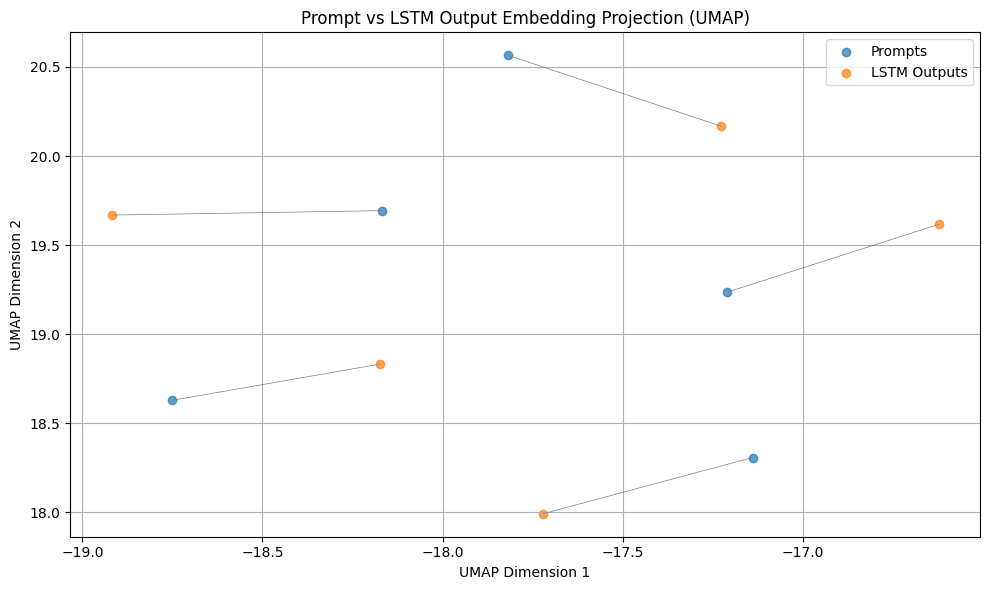

In [ ]:
prompt_embeddings = embedding_model.encode([r["prompt"] for r in results])
output_embeddings = embedding_model.encode([r["generated"] for r in results])
all_embeddings = np.vstack([prompt_embeddings, output_embeddings])

reducer = umap.UMAP(n_components = 2, random_state = 42)
umap_embeddings = reducer.fit_transform(all_embeddings)

n = len(results)
umap_prompts = umap_embeddings[:n]
umap_outputs = umap_embeddings[n:]

plt.figure(figsize = (10, 6))
plt.scatter(umap_prompts[:, 0], umap_prompts[:, 1], label = "Prompts", alpha = 0.7)
plt.scatter(umap_outputs[:, 0], umap_outputs[:, 1], label = "LSTM Outputs", alpha = 0.7)

for i in range(len(results)):
  plt.plot(
      [umap_prompts[i, 0], umap_outputs[i, 0]],
      [umap_prompts[i, 1], umap_outputs[i, 1]],
      c = 'gray', linewidth = 0.5
  )

plt.title("Prompt vs LSTM Output Embedding Projection (UMAP)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()